# Measurement and detection

We'll simulate survey observations based on a simplified model for photon-counting aperture photometry.

We take our instrument to have an (effective) collecting area $A$ and integrates for a time $T$, thus providing an exposure $\epsilon = AT$ toward a targeted source. The expected number of source photons detected from a source with photon number flux $F$ is thus $\epsilon F$.

We suppose there are also backgrounds and instrumental contributions to the detected photons. Sky backgrounds and integrating instrumental backgrounds (such as dark current for a CCD) can be modeled by adding a background rate, $B$, to the flux.  We'll also consider additive contamination with a fixed expected number of counts, $C$ (such as from effects like readout or amplifier noise).  To simplify this example, we consider $B$ and $C$ to be well-measured (i.e., specified constants with no uncertainty).

The total expected number of counts from a source is thus
\begin{align}
\mu(F) & = \epsilon F + \epsilon B + C \\
 & = \epsilon F + \nu
\end{align}
with $\nu \equiv \epsilon B + C$ denoting the expected number of non-source photons.  If the observations comprising the survey have different exposures, $\nu$ will vary from source to source (but still be a known quantity for each source).  For simplicity, we'll suppose for now that the exposures are the same.

In this setup, the data from the observation of a source comprise a single integer, the observed number of counts in aperture, $n$ (we'll use $n_i$ when we consider multiple sources, with $i$ being the source index).

## Simulating observations

To *simulate* observations, we need to specify a *sampling distribution* telling us how to generate data when the source properties are specified.  Here we'll adopot a *Poisson distribution*. The sampling distribution is a probability mass function (PMF) for $n$,
$$
p(n|F) = \frac{(\epsilon F + \nu)^n}{n!} \exp(-\epsilon F + \nu).
$$
When $\mu(F)$ is large, we can approximate this with a normal distribution for $n$, with $F$-dependent mean $\langle n\rangle = \mu(F)$ and $F$-dependent standard deviation $\sigma_n(F) = \sqrt{\mu(F)}$.  But we'll stick with the Poisson distribution, so that we can accurately handle the low-counts regime.

## Estimating source fluxes

Once we have simulated data, we need *member likelihood functions* in order to estimate the source fluxes. Each member likelihood function is given by a Poisson distribution, but now with $n$ *fixed*, and the distribution explored as a function of $F$:
$$
\ell(F) = \frac{(\epsilon F + \nu)^n}{n!} \exp(-\epsilon F + \nu).
$$
This is a continuous function of $F$ (as opposed to a discrete PMF), and it is *not normalized over flux*—it isn't meaningful to integrate it over $F$ without multiplication by a prior (such as a candidate population distribution for $F$).  In fact, most inferences are unaffected by any $F$-independent multiplier in the likelihood, so we may drop the $n!$ in the denominator if we wish, or replace it with a suitable constant that makes $\ell(F)$ have a unity-valued integral, if that happens to be computationally convenient (but don't mistake it for a PDF if you do that!).

When $n$ is large, we can approximate this member likelihood with a Gaussian function (not necessarily a normal distribution, since it needn't be normalized).  The $n$-dependent peak location, $\hat{F}(n)$, can be found by setting $\ell'(\hat{F}) = 0$; this gives
$$
\hat{F}(n) = \frac{n - \nu}{\epsilon},
$$
i.e., the net counts above the backgrounds, divided by the exposure (and thus with the right units—counts per unit area per unit time).  The $n$-dependent standard deviation of the Gaussian can be found by computing a second derivative and matching it to the second derivative of the Gaussian.  The result is
$$
\sigma_F(n) = \frac{\sqrt{n}}{\epsilon},
$$
i.e., the familiar ``root-$n$'' rule, using the *total* counts (not just the net counts appearing in $\hat{F}(n)$.  Uncertainty in the background contribution is contributing to the flux uncertainty.

We'll stick with the Poisson-based expression for $\ell(F)$, which will allow us to accurately treat the low-count regime.  Note that it is a bit like a gamma distribution for $F$, but not quite: it is displaced by $\nu$, and moreover is not normalized to be a PDF.

We went to the trouble of specifying the normal approximations—even though we won't use them—to highlight the sometimes subtle difference between the sampling distribution and the member likelihood function.  With the Poisson representation, the distinction is fairly stark, because the datum is discrete (the integer, $n$), and the source parameter is continuous ($F$).  Adopting the normal approximation, it can be tempting to write down the approximation for the sampling distribution,
$$
p(n|F) \approx \frac{1}{\sigma_n(F)\sqrt{2\pi}} \exp\left[-\frac{(n - \mu(F))^2}{2\sigma^2_n(F)}\right],
$$
and then just use the same function as the member likelihood function for $F$.  But instead one should use
$$
\ell(F) \approx \frac{1}{\sigma_F(n)\sqrt{2\pi}} \exp\left[-\frac{(F - \hat{F}(n))^2}{2\sigma^2_F(n)}\right].
$$
These functions aren't significantly different near their peaks when $F$ and $n$ are large.  The important difference is what determines the location and shape parameters in each function.  For the sampling distribution, the source parameter $F$ determines the location and width.  For the member likelihood function, the datum $n$ determines the location and width.  In particular, the likelihood width is not a quantity that is ``estimated from the data'' (as if there were some ``true'' but unknown $\sigma$ parameter we must estimate, besides $F$). Rather, once the data are known, $\sigma^2_F(n)$ is just a number, fully determined by the data, that specifies the width of the member likelihood function (just like $\hat{F}(n)$ specifies its location).

# Detection

The presence of backgrounds means that photons will be counted in an aperture even in the absence of a source.  To guard against false detections, we will (eventually) introduce a detection threshold, $n_{\rm th}$, requiring that $n > n_{\rm th}$ for a candidate source to enter the survey catalog.  For simplicity, we'll choose $n_{\rm th}$ large enough that the probability for a false detection is negligible, so the catalog is ``pure'' with high probability.

The cost of purity is missing sources—we will preferentially reject dim sources that happen to produce counts below threshold.  To account for this, we need the *detection efficiency*, $\eta(F)$, the probability for detecting a source of flux $F$.  This is just the probability of getting $n > n_{\rm th}$ when $F$ is given:
\begin{align}
\eta(F) 
  &= p(n > n_{\rm th}|F) \\
  &= \sum_{i=n_{\rm th}+1}^\infty p(n|F) \\
  &= \frac{\gamma(n_{\rm th}+1, \epsilon F + \nu)}{n_{\rm th}!},
\end{align}
where $\gamma(s,x)$ is the lower incomplete gamma function; see [Incomplete gamma function - Wikipedia](https://en.wikipedia.org/wiki/Incomplete_gamma_function).  The combination,
$P(s,x) \equiv \gamma(s,x)/\Gamma(s)$ (with $\Gamma(s)$ the gamma function) is called the regularized lower incomplete gamma function; SciPy provides this as `scipy.special.gammainc(s,x)`.  When $s$ is an integer, $\Gamma(s) = (s-1)!$, so `gammainc(n_{\rm th}+1, \epsilon F + \nu)` is just what we need to compute the detection efficiency.

For *simulation*, we needn't compute the efficiency; we can just sample $n$ from a source's Poisson distribution, and if $n\le n_{\rm th}$, we ignore that source.  But for *likelihood-based inference*, we must explicitly use the efficiency function in computing the probability for the collection of detection-filtered data.

# Population model

Astrophysically, a flux distribution arises from the joint spatial and luminosity distribution of sources.  With distance measurements, we can convert flux estimates to luminosity estimates, and learn the luminosity distribution in some detail.  But often distance measurements are unavailable.  One then focuses on modeling the *univariate* flux distribution—the "number-size distribution," "$\log-N/\log-S$" distribution, or "number counts."

With candidate luminosity and spatial distributions, one can compute the implied flux distribution via a kind of convolution (known in olden times as the *fundamental equation of stellar statistics* when applied to star counts).  But often an analyst will simply posit a phenomenological univariate flux distribution model, to characterize the observations without making specific spatial and luminosity function assumptions.  Power laws and related functions are common models, motivated in part by the (cumulative) $3/2$-law (or its $5/2$ density counterpart).  We'll do that here.

Let $g(F; \theta)$ denote the flux distribution probability density function $PDF$, with parameters $\theta$ (that we will sometimes suppress).  Choose a *fiducial flux*, $F_0$; it may be a physically interesting scale (e.g., a solar luminosity at 10 pc), or simply a convenient unit (e.g., $10^{-7}$ photons/cm$^2$/s).  Switch to log space using
$$
x = \log\left(\frac{F}{F_0}\right), \qquad\qquad
y = \log\left(\frac{g(F)}{g(F_0)}\right).
$$
(We introduced the fiducial flux in order to make the arguments of the logarithms dimensionless; we use the natural logarithm here.)  A power law is a straight line in $(x,y)$ space; its slope is the *power law index* (sometimes the negative slope is called the index).  That is, if
$$
g(F) = C\left(\frac{F}{F_0}\right)^\alpha,
$$
with $C$ a normalization constant, then it's easy to verify that
$$
\frac{dy}{dx} = \alpha.
$$
This corresponds to $y = \alpha x + C$, via integration—the equation for a line.

Let's generalize this a bit, seeking to make the power law index vary with flux.  Let's pick $F_0$ to be the flux at which the slope is $\alpha$, and let the slope change linearly away from there.  This leads to
$$
\frac{dy}{dx} = \alpha + \beta x.
$$
This corresponds to power law behavior with index $\alpha$ at $\xi$, but with the index linearly "rolling" with respect to log-flux.
  
What does such a choice imply for the flux distribution?
First note that although $g(F)$ is a PDF for $F$, it's not the case that $y(x)$ is a PDF for $x$.  The nonlinear change of variables from $F$ to $x$ means that the PDF for $x$, $h(x)$, must be computed using a Jacobian:
\begin{align}
h(x) 
  &= g(F(x))\left|\frac{dF}{dx}\right| \\
  &= g[F_0 e^x]\, F_0 e^x.
\end{align}
(Check the dimensions!)  Conversely, if we specify the PDF for the log-flux, we can compute $g(F)$ via
\begin{align}
g(F) 
  &= h(x(F))\left|\frac{dx}{dF}\right| \\
  &= \frac{1}{F} h[\log(F/F_0)].
\end{align}
(Check the dimensions again!)

Now suppose that $h(x)$ is a normal distribution (for $x$, the log-flux), with mean $\mu$ and standard deviation $\sigma$ (both dimensionless).  That is, suppose $h(x)$ is a function whose logarithm is *quadratic* (parabolic).  We then have
$$
h(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right].
$$
This corresponds to a $g(F)$ given by the Jacobian rule above:
$$
g(F) = \frac{1}{F}\cdot\frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(\log(F/F_0) - \mu)^2}{2\sigma^2}\right].
$$
This is a *log-normal distribution* for the flux.

Now compute its slope in $(x,y)$ log space.  The result is
$$
\frac{dy}{dx} = \left(\frac{\mu}{\sigma^2} - 1\right) - \frac{x}{\sigma^2}.
$$
Comparing with our linearly-rolling law, above, we see that a log-normal distribution corresponds to a rolling power law with index $\alpha = \mu/\sigma^2 -1$ at $F=F_0$, and with rate of change of slope $\beta = -1/\sigma^2$.  Note that $\beta$ must be negative.

So a log-normal flux distribution will look like a power law with index $\alpha = \mu/\sigma^2-1$ if $\beta$ is small (i.e., $\sigma$ is large).  Estimating $\beta$ measures departure from pure power law behavior.

# Parameter choices

For our simulation we must specify the survey parameters governing measurement and detection, and a choice of parameters for the underlying "true" flux distribution.

First let's specify the detection threshold.  A convenient and common specification is to choose $n_{\rm th}$ so that $\hat{F}(n_{\rm th})$ is some fixed multiple, $k$, of the uncertainty, $\sigma_F(n_{\rm th})$ (i.e., we require detections to be above "$k$ sigma").  This corresponds to solving
$$
\hat{F}(n_{\rm th}) = k\, \sigma_F(n_{\rm th})
$$
for $n_{\rm th}$.  This gives an equation involving $n_{\rm th}$ and $\sqrt{n_{\rm th}}$, i.e., a quadratic equation for $\sqrt{n_{\rm th}}$.  The solution is
$$
n_{\rm th} = k^2\, \left(\frac{1 + \sqrt{1 + 4\nu/k^2}}{2}\right)^2.
$$
Note that if the expected background contribution $\nu=0$, we have $n_{\rm th} = k^2$, a result we would have guessed from the root-$n$ rule.

As a starting point, let's use a 4-$\sigma$ detection criterion, with $\nu = 9.373$, for which
$$
n_{\rm th} = 2 k^2 = 32.
$$

Now we must specify the effective area and integration time, or equivalently, the exposure, $\epsilon$.  Since only the product, $\epsilon F$, enters the calculations, for any choice of flux scale, we can find an exposure that will produce any desired photon count expectation value.  We'll choose the exposure so that the expected counts will equal $n_{\rm th}$ for a flux $F = 0.1 F_0$; that is, we set
$$
0.1 \epsilon F_0 + \nu = n_{\rm th},
$$
which gives $\epsilon = 320/F_0$.  We can set $F_0$ to a specific value; alternatively we can work in terms of a dimensionless flux, $f = F/F_0$.  We'll keep things dimensionless now.  But just to set a relevant scale:  For SDDS observations in the Sloan r band, in a typical 53.9 s exposure the expected number of r-band counts from a solar-luminosity source at 1 Mpc is $\approx 2$.

For the population model, let's set the index at $F_0$ to have rolled off of the canonical homogenous population value, $\alpha = -5/2$, by one, i.e., $\alpha = -1.5$ (this will lead to bright sources have an index closer to the homogeneous value, as is often the case).  We can try a couple values of the roll rate parameter, $\beta$, to explore what is measurable.  As a starting point we'll consider $\beta = -0.25$.  When the flux reaches $\approx 50\times F_0$, the log-slope reaches the $-5/2$ value.

In [1]:
# Pollute the namespace!
from matplotlib.pyplot import *
from scipy import *

from scipy.stats import poisson, lognorm
from scipy.special import gammainc

%matplotlib inline

In [2]:
# Constants for the survey:
k = 4.  # k-sigma threshold
nu = 9.373  # expected background contribution
n_th = k**2 * (0.5 + 0.5*sqrt(1. + 4.*nu/k**2))**2
print('Detection threshold: ', n_th)

expo = (32 - nu)/0.1

Detection threshold:  32.00064506


In [3]:
def ecounts(f):
    """
    Compute the expected counts for a source with dimensionless flux f.
    """
    return expo*f + nu

def f_est(n):
    """
    Compute a (dimensionless) flux estimate, given the number of observed
    photons, n.
    
    Returns a tuple: (f_hat, sig_f).
    """
    return (n - nu)/expo, sqrt(n)/expo

def eta(f):
    """
    Detection efficiency for sources with dimensionless flux f.
    """
    return gammainc(n_th+1., expo*f + nu)

In [4]:
# Quick checks:

# Setting n exactly equal to its expectation should give
# a perfect f_hat estimate.
print('f_hat should be 1:', f_est(ecounts(1)))

# Expected counts from a flux of 0.1*F_0 should be at threshold:
print('Expected counts at f=.1 vs. thresold:', ecounts(.1), n_th)

f_hat should be 1: (1.0, 0.067842258089536464)
Expected counts at f=.1 vs. thresold: 32.0 32.00064506


Text(0,0.5,'Efficiency')

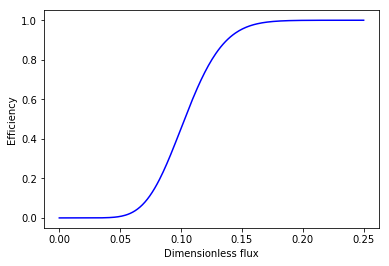

In [5]:
# Plot the detection efficiency.

f_vals = linspace(0., 0.25, 250)
eta_vals = eta(f_vals)
plot(f_vals, eta_vals, 'b-')
xlabel('Dimensionless flux')
ylabel('Efficiency')

Caution below:  SciPy has a peculiar (albeit internally consistent) way of defining the lognormal distribution.  Note that Stan uses a different parameterization.

mu, sig =  -2.0 2.0
Index is -5/2 at f = 54.5981500331


Text(0,0.5,'PDF')

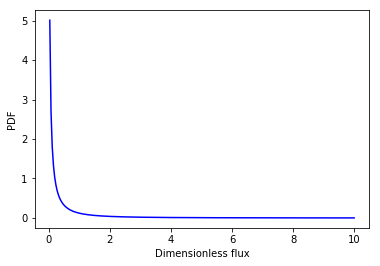

In [6]:
alpha, beta = -1.5, -0.25  # fiducial index, roll rate

# Derived params for lognormal:
sig = 1./sqrt(-beta)
mu = sig**2 * (alpha + 1.)
print('mu, sig = ', mu, sig)

print('Index is -5/2 at f =', exp((-5/2. - alpha)/beta))

# SciPy's funky scale param;
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
emu = exp(mu)
shape = sig

popn = lognorm(shape, scale=emu)

f_vals = linspace(0.03, 10, 250)
pdf_vals = popn.pdf(f_vals)
plot(f_vals, pdf_vals, 'b-')
xlabel('Dimensionless flux')
ylabel('PDF')

Text(0,0.5,'Flux PDF')

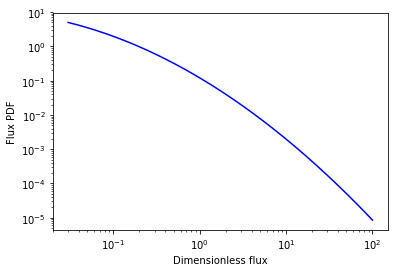

In [7]:
f_vals = logspace(log10(0.03), log10(100), 250)
pdf_vals = popn.pdf(f_vals)
loglog(f_vals, pdf_vals, 'b-')
xlabel('Dimensionless flux')
ylabel('Flux PDF')

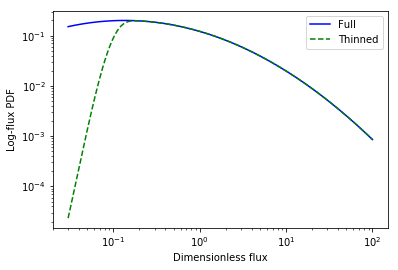

In [8]:
# Show the log-space PDF; geometric area on this
# plot shows where the sources are distributed in flux.

pdf_vals = f_vals*popn.pdf(f_vals)
loglog(f_vals, pdf_vals, 'b-', label='Full')
loglog(f_vals, eta(f_vals)*pdf_vals, 'g--', label='Thinned')
# ylim(.002, .2)
xlabel('Dimensionless flux')
ylabel('Log-flux PDF')
legend()

In [9]:
# Draw sets of samples, without and with selection.

# These will hold the data, i.e., counts.
all, detected = [], []

# Keep track of true fluxes.
true_all, true_det = [], []

# These will hold dimensionless flux estimates.
est_all, est_det = [], []

ndet = 1000
nd = 0
while nd < ndet:
    f = popn.rvs()
    true_all.append(f)
    # print(f)
    n = poisson(ecounts(f)).rvs()
    est = f_est(n)
    all.append(n)
    est_all.append(est)
    if n > n_th:
        true_det.append(f)
        detected.append(n)
        est_det.append(est)
        nd += 1

all = array(all)
detected = array(detected)
true_all = array(true_all)
true_det = array(true_det)
est_all = array(est_all)
est_det = array(est_det)

print(len(all), 'sources to get', len(detected), 'detected.')

1769 sources to get 1000 detected.


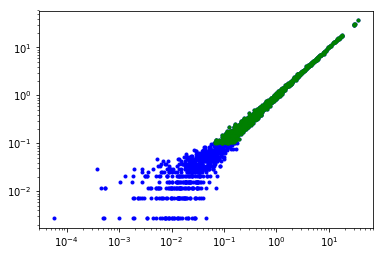

In [10]:
# Visual fidelity check of flux estimates.

loglog(true_all, est_all[:,0], 'b.')
loglog(true_det, est_det[:,0], 'g.')

Text(0,0.5,'Counts')

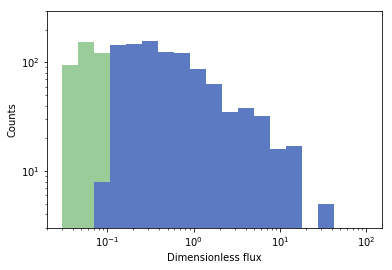

In [11]:
l, u = log10(.03), log10(100.)
hist(est_all[:,0], bins=logspace(l, u, 20), log=True, color='g', alpha=.4)
hist(est_det[:,0], bins=logspace(l, u, 20), log=True, color='b', alpha=.4)
gca().set_xscale("log")
ylim(3, 300)
xlabel('Dimensionless flux')
ylabel('Counts')